Using TensorFlow backend.


Read  3717


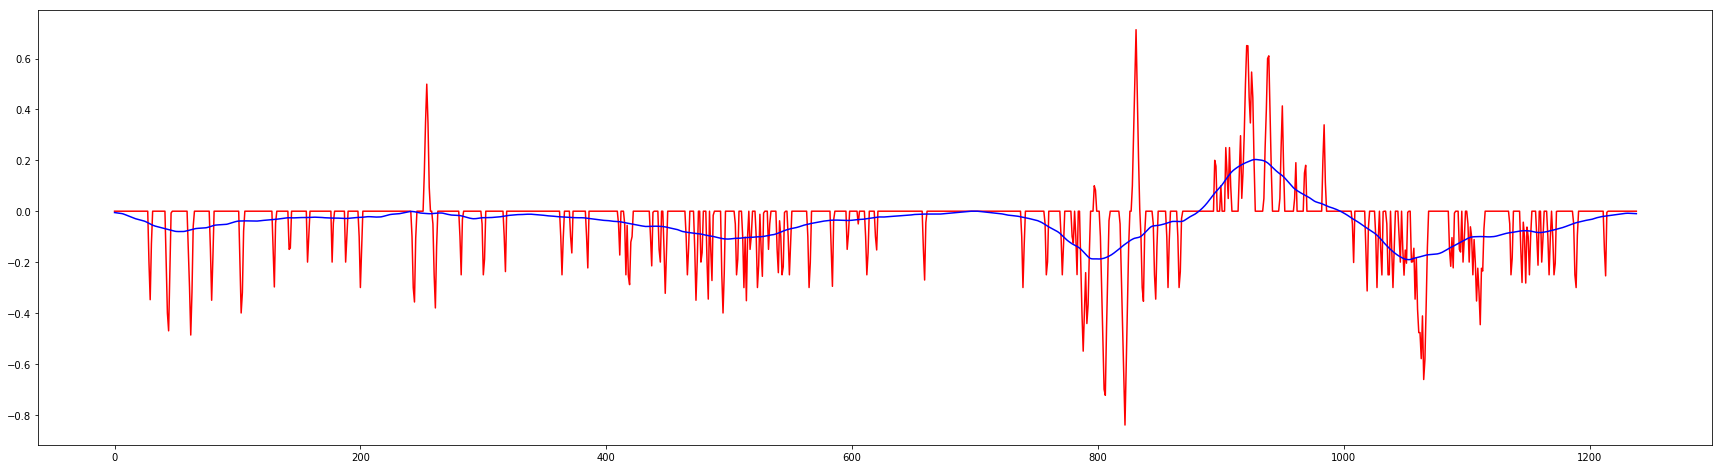

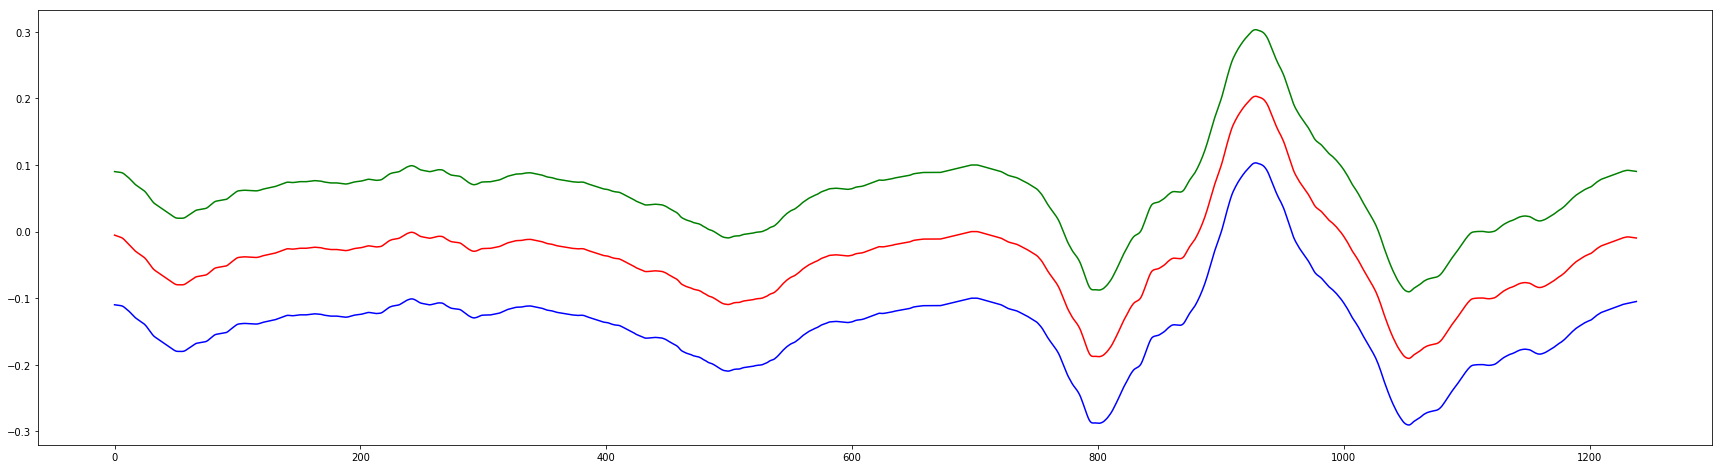

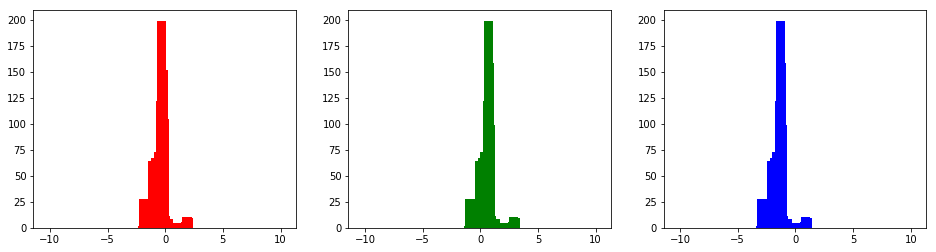

train_samples      =  2973
validation_samples =  744
Resize sample size to avoid Keras warning
train_samples      =  2944
validation_samples =  736


In [1]:
import utils
import numpy as np

path = 'data/track1-center/'
train_generator, validation_generator, train_size, valid_size = \
    utils.generate_train_data(utils.load_data(path,True))

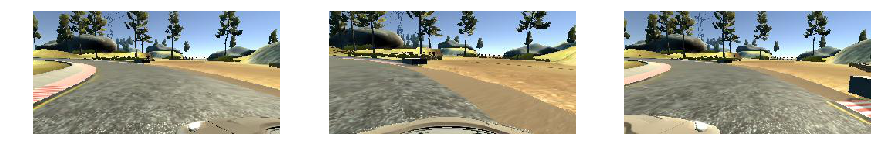

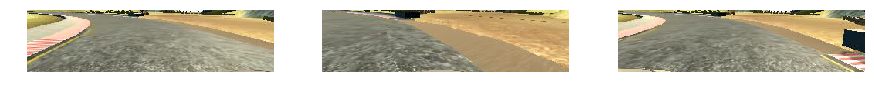

In [11]:
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def crop(img):
    width = img.size[0]
    height = img.size[1]
    crop_top = 60
    crop_bottom = 20
    img_cropped = img.crop((0,
                            crop_top,
                            width,
                            height - crop_bottom))
    return img_cropped

def plot(images):
    plt.figure(figsize=(15,15))
    plt.subplot(1, 3, 1)
    plt.imshow(images[0])
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(images[1])
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.imshow(images[2])
    plt.axis('off')
    plt.show()

%matplotlib inline
# file = "data/track1-center/IMG/center_2017_06_10_00_43_05_338.jpg"
file = "data/track1-center1/IMG/left_2017_06_10_17_28_39_772.jpg"
file1 = "data/track1-center1/IMG/center_2017_06_10_17_28_39_772.jpg"
file2 = "data/track1-center1/IMG/right_2017_06_10_17_28_39_772.jpg"

imgs= [Image.open(file),Image.open(file1),Image.open(file2)]
imgs_cropped = [crop(imgs[0]),crop(imgs[1]),crop(imgs[2])]
plot(imgs)
plot(imgs_cropped)

Steering predict = -2.3101219907402992


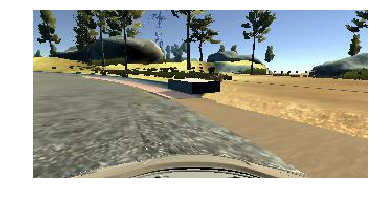

In [2]:
from keras.models import load_model
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

#img_file = "data/track1-center1/IMG/right_2017_06_10_17_28_39_772.jpg"
img_file = "correction/2017_06_19_03_20_26_828.jpg"

model = load_model('model_nvidia1.h5')
img = Image.open(img_file)
image_array = np.asarray(img)
steering_angle = float(model.predict(image_array[None, :, :, :], batch_size=1))
print("Steering predict = {}".format(steering_angle*25))
plt.imshow(img)
plt.axis('off')
plt.show()

In [21]:
import os
path = 'correction'
files = os.listdir(path)
files = [os.path.join(path, file) for file in files]
print(files)

['correction/2017_06_19_01_39_41_722.jpg', 'correction/2017_06_19_02_39_58_524.jpg', 'correction/2017_06_19_01_39_41_547.jpg', 'correction/2017_06_19_02_39_58_550.jpg', 'correction/2017_06_19_02_39_58_500.jpg', 'correction/2017_06_19_02_39_57_408.jpg', 'correction/2017_06_19_02_36_22_796.jpg', 'correction/2017_06_19_01_39_41_606.jpg', 'correction/2017_06_19_02_39_58_773.jpg', 'correction/2017_06_19_02_39_57_924.jpg', 'correction/2017_06_19_01_39_41_813.jpg', 'correction/2017_06_19_02_39_58_618.jpg', 'correction/2017_06_19_02_39_58_025.jpg', 'correction/2017_06_19_02_39_57_431.jpg', 'correction/2017_06_19_02_36_22_925.jpg', 'correction/2017_06_19_02_39_57_457.jpg', 'correction/2017_06_19_02_36_22_700.jpg', 'correction/2017_06_19_02_39_58_666.jpg', 'correction/2017_06_19_01_39_41_788.jpg', 'correction/2017_06_19_02_39_57_585.jpg', 'correction/2017_06_19_02_39_58_224.jpg', 'correction/2017_06_19_02_39_57_875.jpg', 'correction/2017_06_19_02_39_57_764.jpg', 'correction/2017_06_19_01_39_41_6

Using TensorFlow backend.


Read  3933
Testing prediction on 1311 images
Plotting results  27


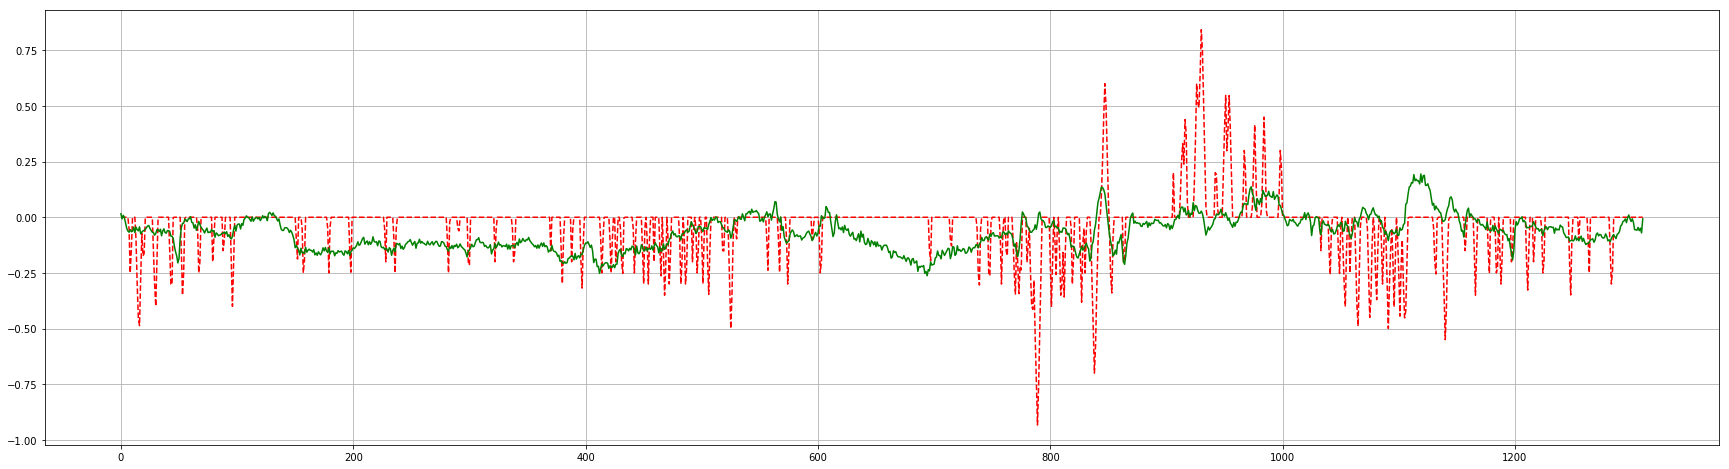

Result: [Ground truth | Prediction | Error]


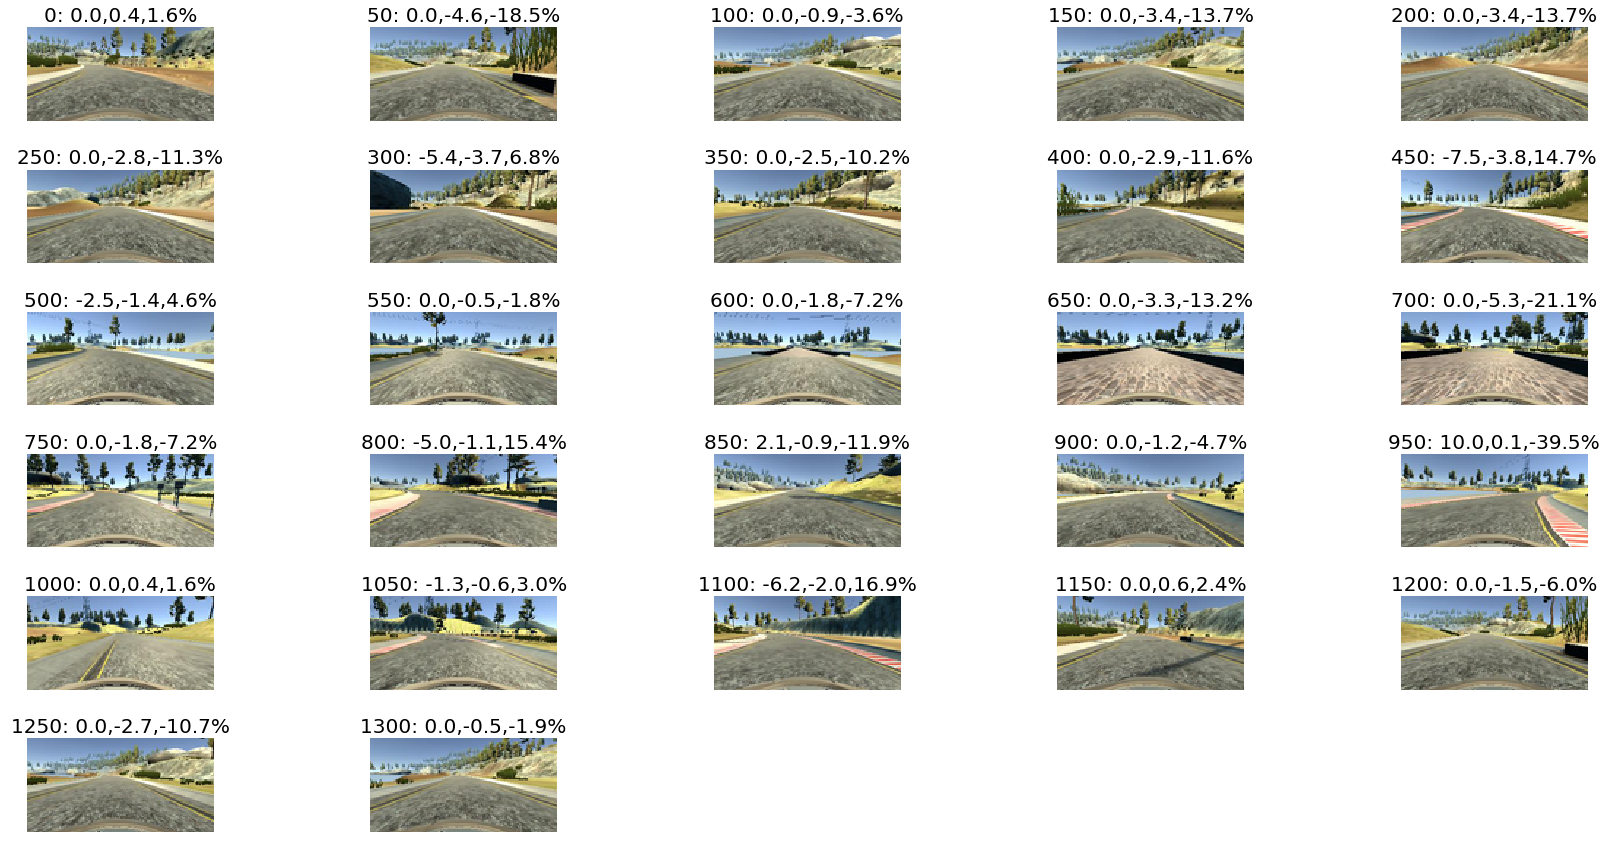

Test completed


In [1]:
import utils
utils.unit_test('model_nvidia1.h5','data/track1-center1/')

Read  4305
Testing prediction on 1435 images
Plotting results  29


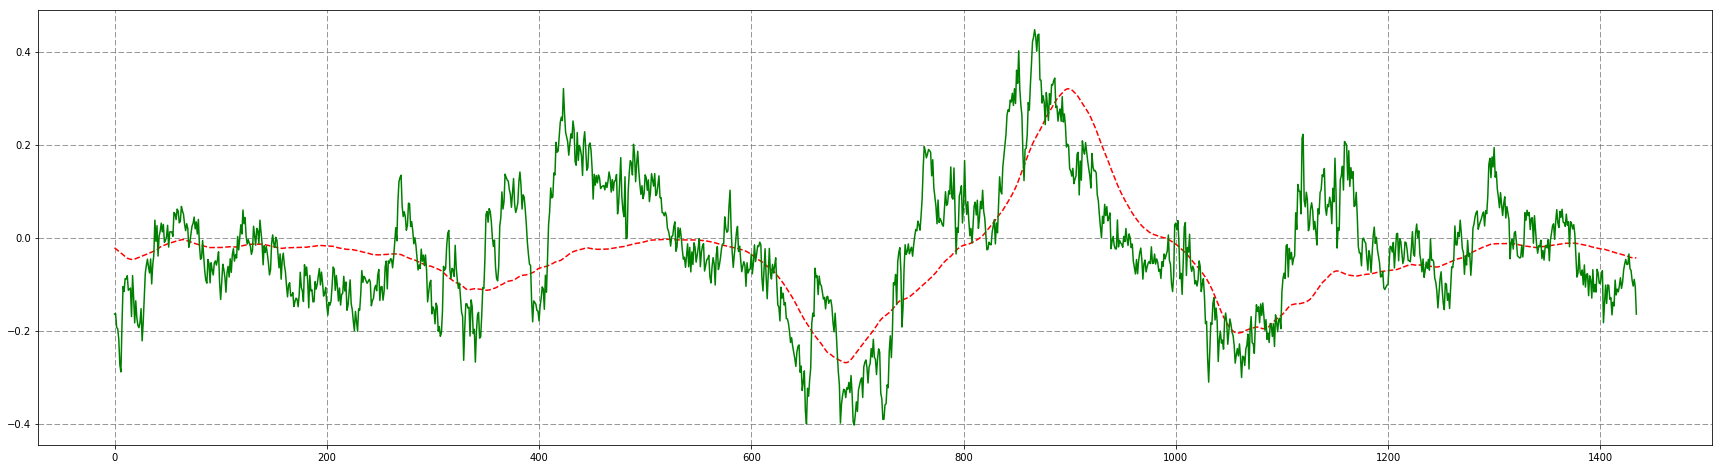

Result: [Ground truth | Prediction | Error]


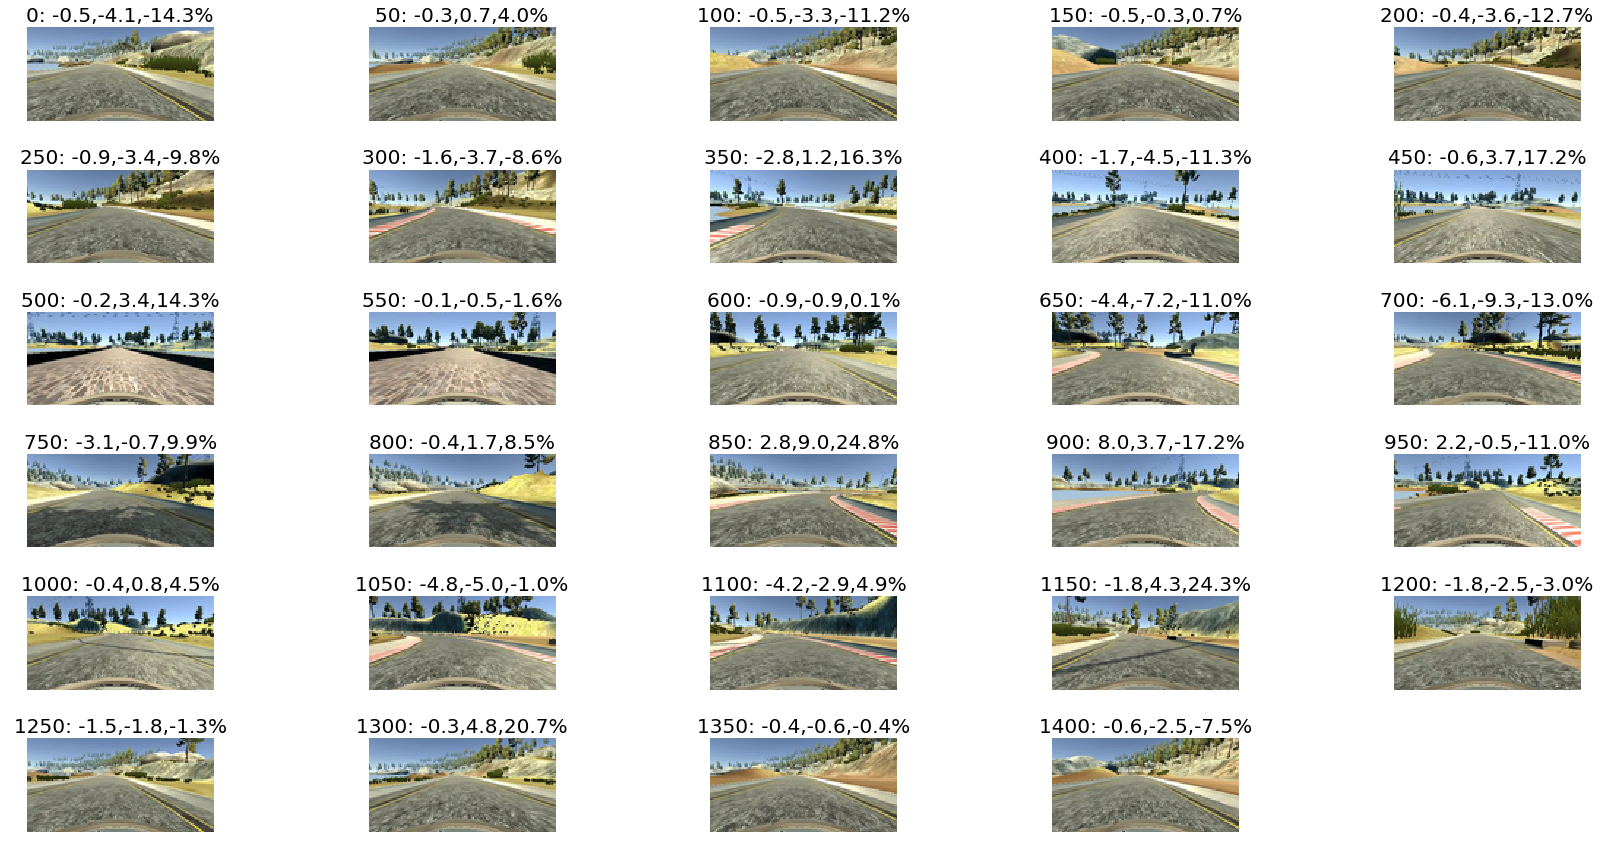

Test completed


In [2]:
import utils
utils.unit_test('model.h5','data/track1-test/')